# Android malware detection

## Business objective

The goal here is to detect if there is presence of malware by using the attributes extracted from Android applications as features.

The associated [dataset](https://www.kaggle.com/datasets/shashwatwork/android-malware-dataset-for-machine-learning?datasetId=1208878&sortBy=voteCount) contains 215 features extracted from 15,036 applications (5,560 malware apps from Drebin project and 9,476 benign apps).

![Android malware image](https://securityintelligence.com/wp-content/uploads/2014/04/201310DIY-Android-Malware-Analysis-Taking-apart-OBAD-630x330.jpg)


## Environment setup

In [21]:
import platform

print(f"Python version: {platform.python_version()}")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(f"NumPy version: {np.__version__}")

Python version: 3.11.1
NumPy version: 1.23.5


In [22]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = "retina"
sns.set()

In [23]:
import sklearn

print(f"scikit-learn version: {sklearn.__version__}")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, precision_score, recall_score

scikit-learn version: 1.2.2


In [24]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

# Device configuration
print("GPU found :)" if tf.config.list_physical_devices("GPU") else "No available GPU :/")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

TensorFlow version: 2.12.0
Keras version: 2.12.0
GPU found :)


In [25]:
# Utility functions

def plot_planar_data(X, y):
    """Plot some 2D data"""

    plt.figure()
    plt.plot(X[y == 0, 0], X[y == 0, 1], "or", alpha=0.5, label=0)
    plt.plot(X[y == 1, 0], X[y == 1, 1], "ob", alpha=0.5, label=1)
    plt.legend()


def plot_decision_boundary(pred_func, X, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)


def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy
    Takes a Keras History object as parameter"""

    loss = history.history["loss"]
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, ".--", label="Training loss")
    final_loss = loss[-1]
    title = "Training loss: {:.4f}".format(final_loss)
    plt.ylabel("Loss")
    if "val_loss" in history.history:
        val_loss = history.history["val_loss"]
        plt.plot(epochs, val_loss, "o-", label="Validation loss")
        final_val_loss = val_loss[-1]
        title += ", Validation loss: {:.4f}".format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history["accuracy"]

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, ".--", label="Training acc")
    final_acc = acc[-1]
    title = "Training accuracy: {:.2f}%".format(final_acc * 100)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    if "val_accuracy" in history.history:
        val_acc = history.history["val_accuracy"]
        plt.plot(epochs, val_acc, "o-", label="Validation acc")
        final_val_acc = val_acc[-1]
        title += ", Validation accuracy: {:.2f}%".format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

## Data loading and preparation


In [26]:
dataset_url = "https://raw.githubusercontent.com/ensc-fc/ai4d2023/main/data/drebin-215-dataset-5560malware-9476-benign.csv"
df_malware = pd.read_csv(dataset_url)

print(f"Dataset shape: {df_malware.shape}")

Dataset shape: (15036, 216)


/var/folders/wh/j8m7jl9j3tj9qt_f4wjc2_7h0000gq/T/ipykernel_60758/193193955.py:2: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  df_malware = pd.read_csv(dataset_url)


In [27]:
df_malware.sample(n=10)

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
13509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,B
3166,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
5343,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
5612,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
8098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,B
11854,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,1,1,0,0,0,B
11483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,B
13791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
2689,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,1,S
1643,0,0,0,0,0,0,1,0,0,0,...,1,0,0,1,1,0,0,0,0,S


In [28]:
df_malware.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15036 entries, 0 to 15035
Columns: 216 entries, transact to class
dtypes: int64(214), object(2)
memory usage: 24.8+ MB


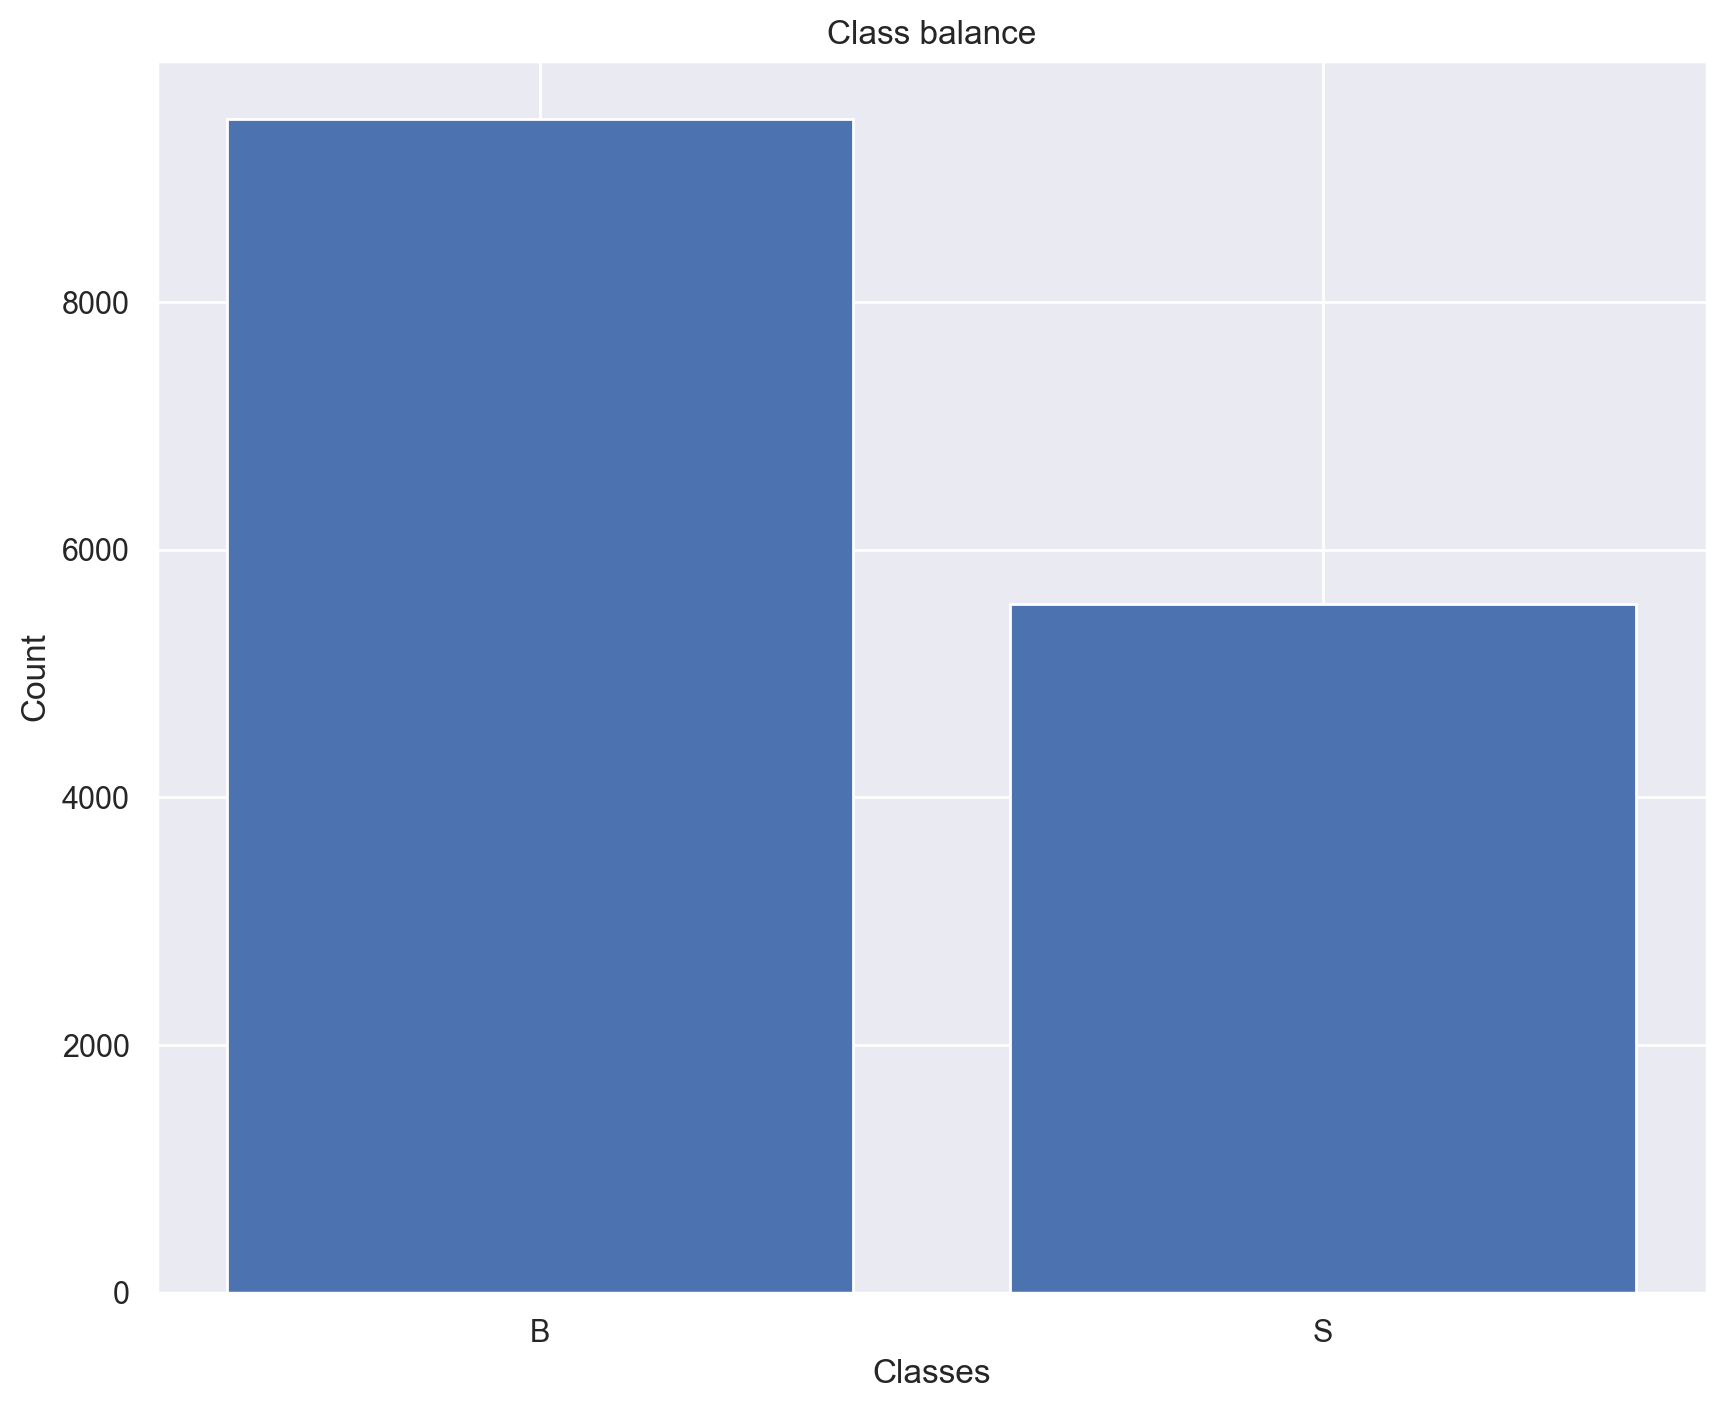

In [29]:
classes, count = np.unique(df_malware["class"], return_counts=True)

plt.bar(classes, count)
plt.title("Class balance")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

### Data preprocessing

The output class contains categorical values 'B' and 'S'. We have to encode them into integer values.

The dataset also contains some random characters like '?' and 'S'. We can set them to `NaN` then remove them.


In [30]:
# Perform Label Encoding
lbl_enc = LabelEncoder()
print(classes, lbl_enc.fit_transform(classes))

df_malware.replace(classes,lbl_enc.fit_transform(classes), inplace=True)

['B' 'S'] [0 1]


In [31]:
df_malware.replace('[?,S]', np.NaN, regex=True, inplace=True)

print(f"Total missing values : {sum(list(df_malware.isna().sum()))}")
df_malware.dropna(inplace=True)
                                
for c in df_malware.columns:
    df_malware[c] = pd.to_numeric(df_malware[c])

Total missing values : 5


In [32]:
df_malware.sample(n=10)

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
11435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8491,1,1,1,1,1,1,0,1,1,1,...,0,0,0,1,0,0,0,0,0,0
554,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
12250,1,1,1,1,1,1,0,1,1,1,...,0,0,0,1,1,0,0,0,0,0
13163,1,1,1,1,1,1,0,1,1,1,...,0,0,0,1,1,1,0,0,0,0
4917,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1
12481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
12370,1,1,1,1,1,1,1,1,0,1,...,1,0,0,1,1,1,0,0,0,0


### Traning and test datasets preparation

In [33]:
x_train, x_test, y_train, y_test = train_test_split(df_malware[df_malware.columns[:len(df_malware.columns)-1]].to_numpy(),
    df_malware[df_malware.columns[-1]].to_numpy(),
    test_size = 0.2)

print(f"Training input: {x_train.shape}, training labels: {y_train.shape}")
print(f"Test input: {x_test.shape}, test labels: {y_test.shape}")

Training input: (12024, 215), training labels: (12024,)
Test input: (3007, 215), test labels: (3007,)


## Model training and evaluation

In [34]:
# Create the nn model
ann_model = Sequential()

ann_model.add(Dense(100, activation="relu", input_shape=(215,)))
ann_model.add(Dense(1, activation="sigmoid"))

# Describe the model
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               21600     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 21,701
Trainable params: 21,701
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
301/301 [==============================] - 3s 8ms/step - loss: 0.1742 - accuracy: 0.9405 - val_loss: 0.0949 - val_accuracy: 0.9676
Epoch 2/10
301/301 [==============================] - 2s 7ms/step - loss: 0.0791 - accuracy: 0.9737 - val_loss: 0.0802 - val_accuracy: 0.9746
Epoch 3/10
301/301 [==============================] - 2s 8ms/step - loss: 0.0664 - accuracy: 0.9775 - val_loss: 0.0823 - val_accuracy: 0.9742
Epoch 4/10
301/301 [==============================] - 2s 8ms/step - loss: 0.0612 - accuracy: 0.9791 - val_loss: 0.0793 - val_accuracy: 0.9780
Epoch 5/10
301/301 [==============================] - 2s 7ms/step - loss: 0.0580 - accuracy: 0.9814 - val_loss: 0.0811 - val_accuracy: 0.9813
Epoch 6/10
301/301 [==============================] - 2s 7ms/step - loss: 0.0558 - accuracy: 0.9830 - val_loss: 0.0836 - val_accuracy: 0.9813
Epoch 7/10
301/301 [==============================] - 2s 8ms/step - loss: 0.0560 - accuracy: 0.9821 - val_loss: 0.0847 - val_accuracy: 0.9817
Epoch 

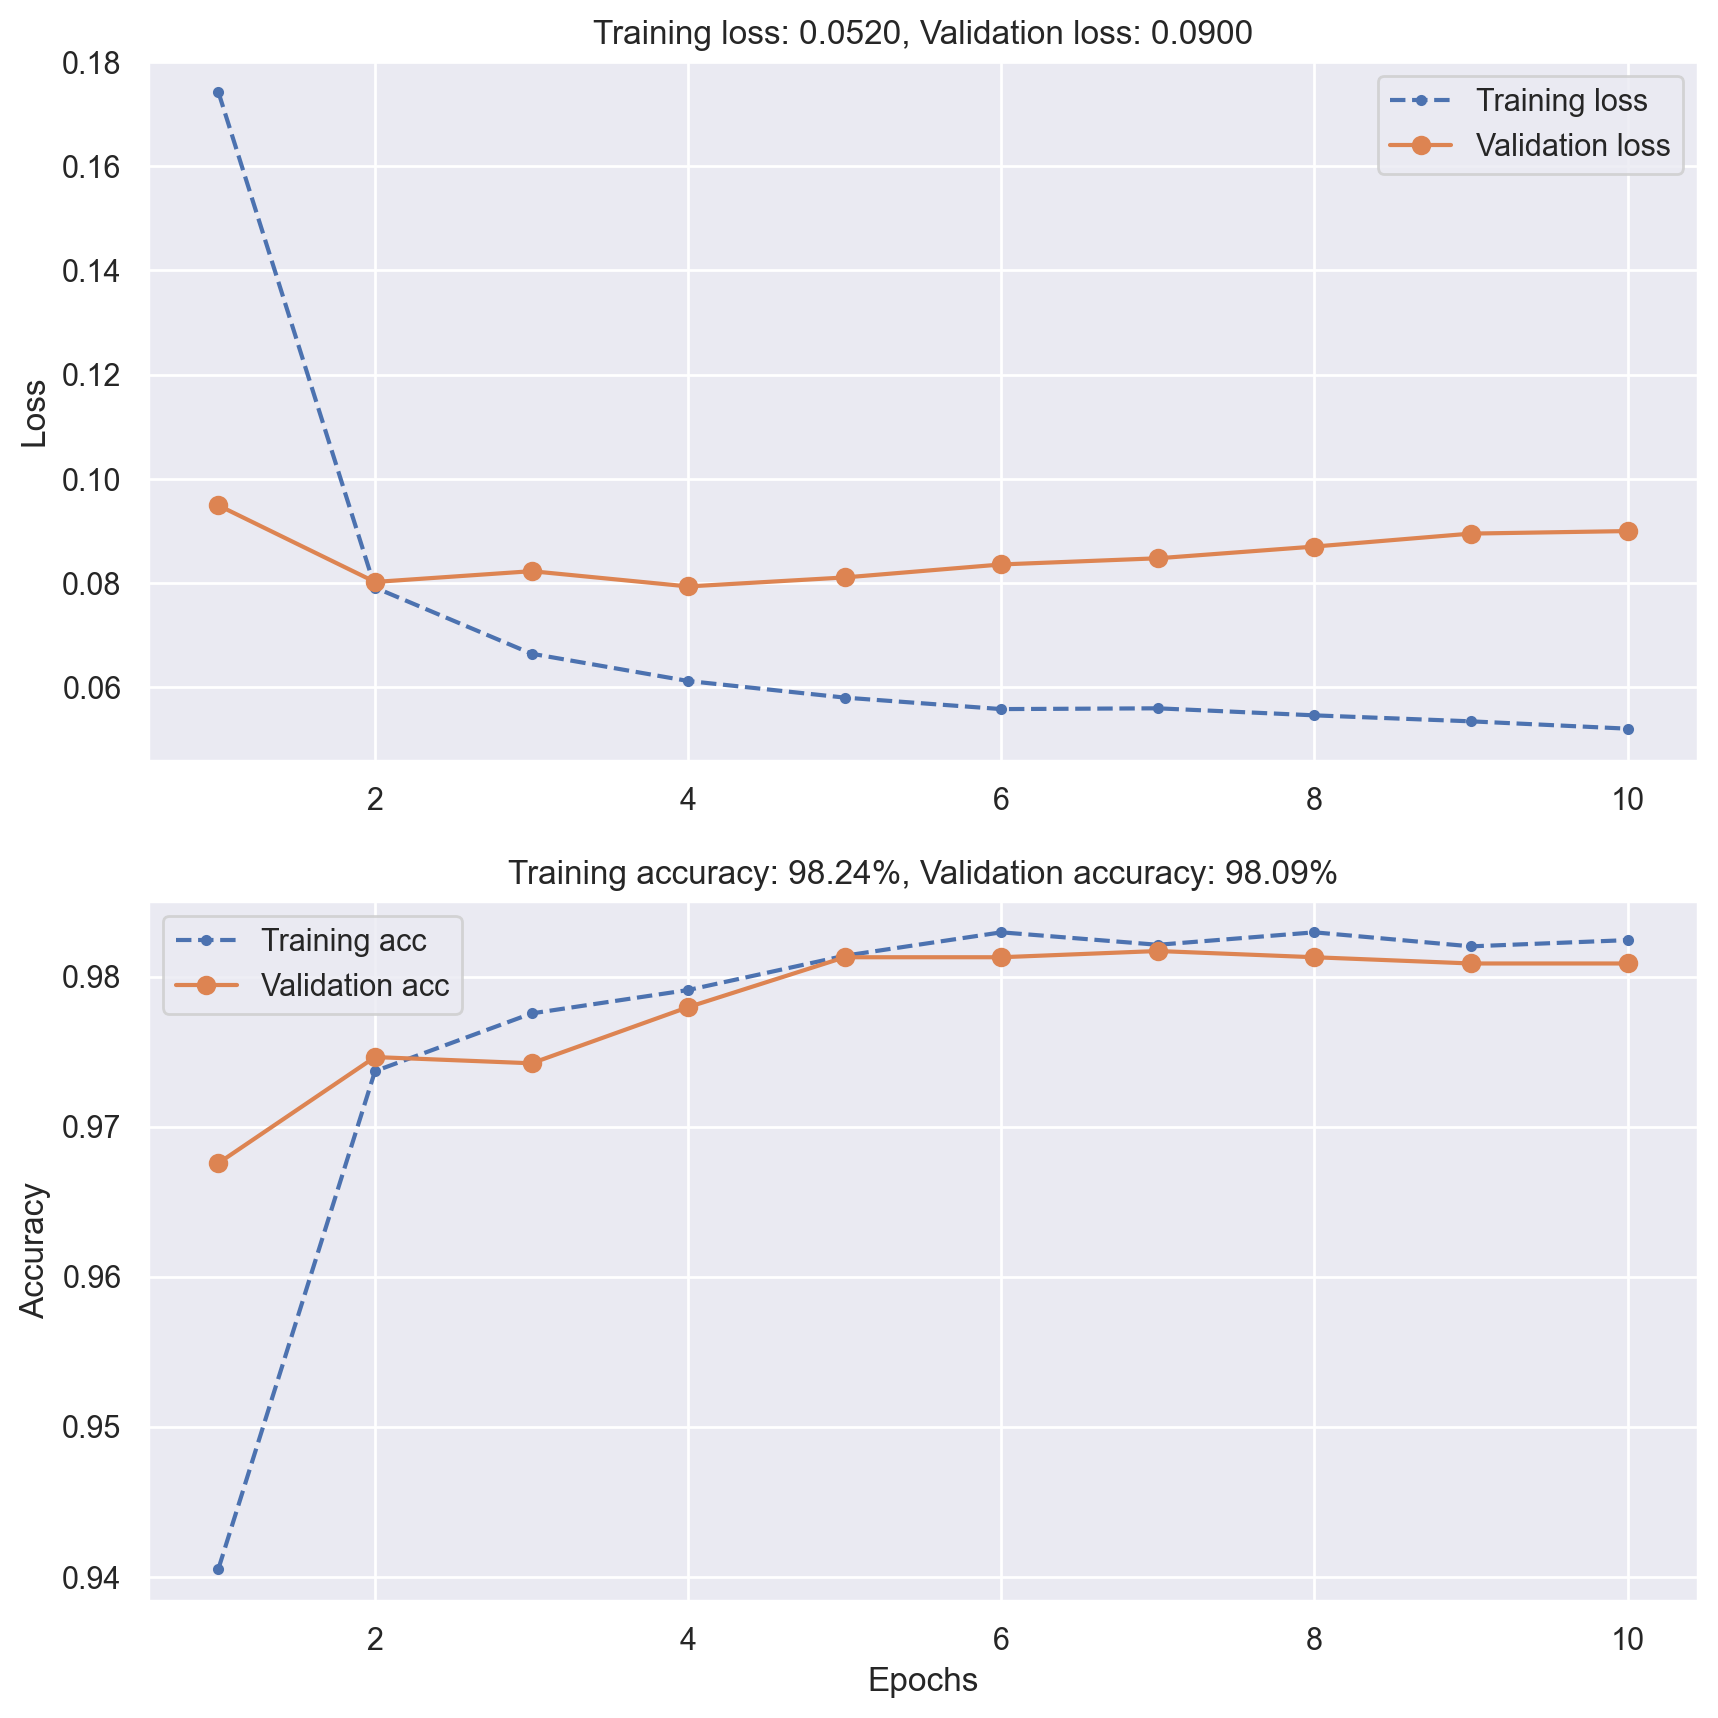

In [35]:
# Train the model and show results
ann_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

history = ann_model.fit(x_train, y_train, epochs=10, batch_size=32,
                        validation_split=0.2)
plot_loss_acc(history)

In [36]:
# Predict results for test set
y_pred = ann_model.predict(x_test)

# Transform result values in either 0 or 1
for i in range(len(y_pred)):
    if y_pred[i] > (1 - y_pred[i]):
        y_pred[i] = 1
    else:
        y_pred[i] = 0

94/94 [==============================] - 0s 2ms/step


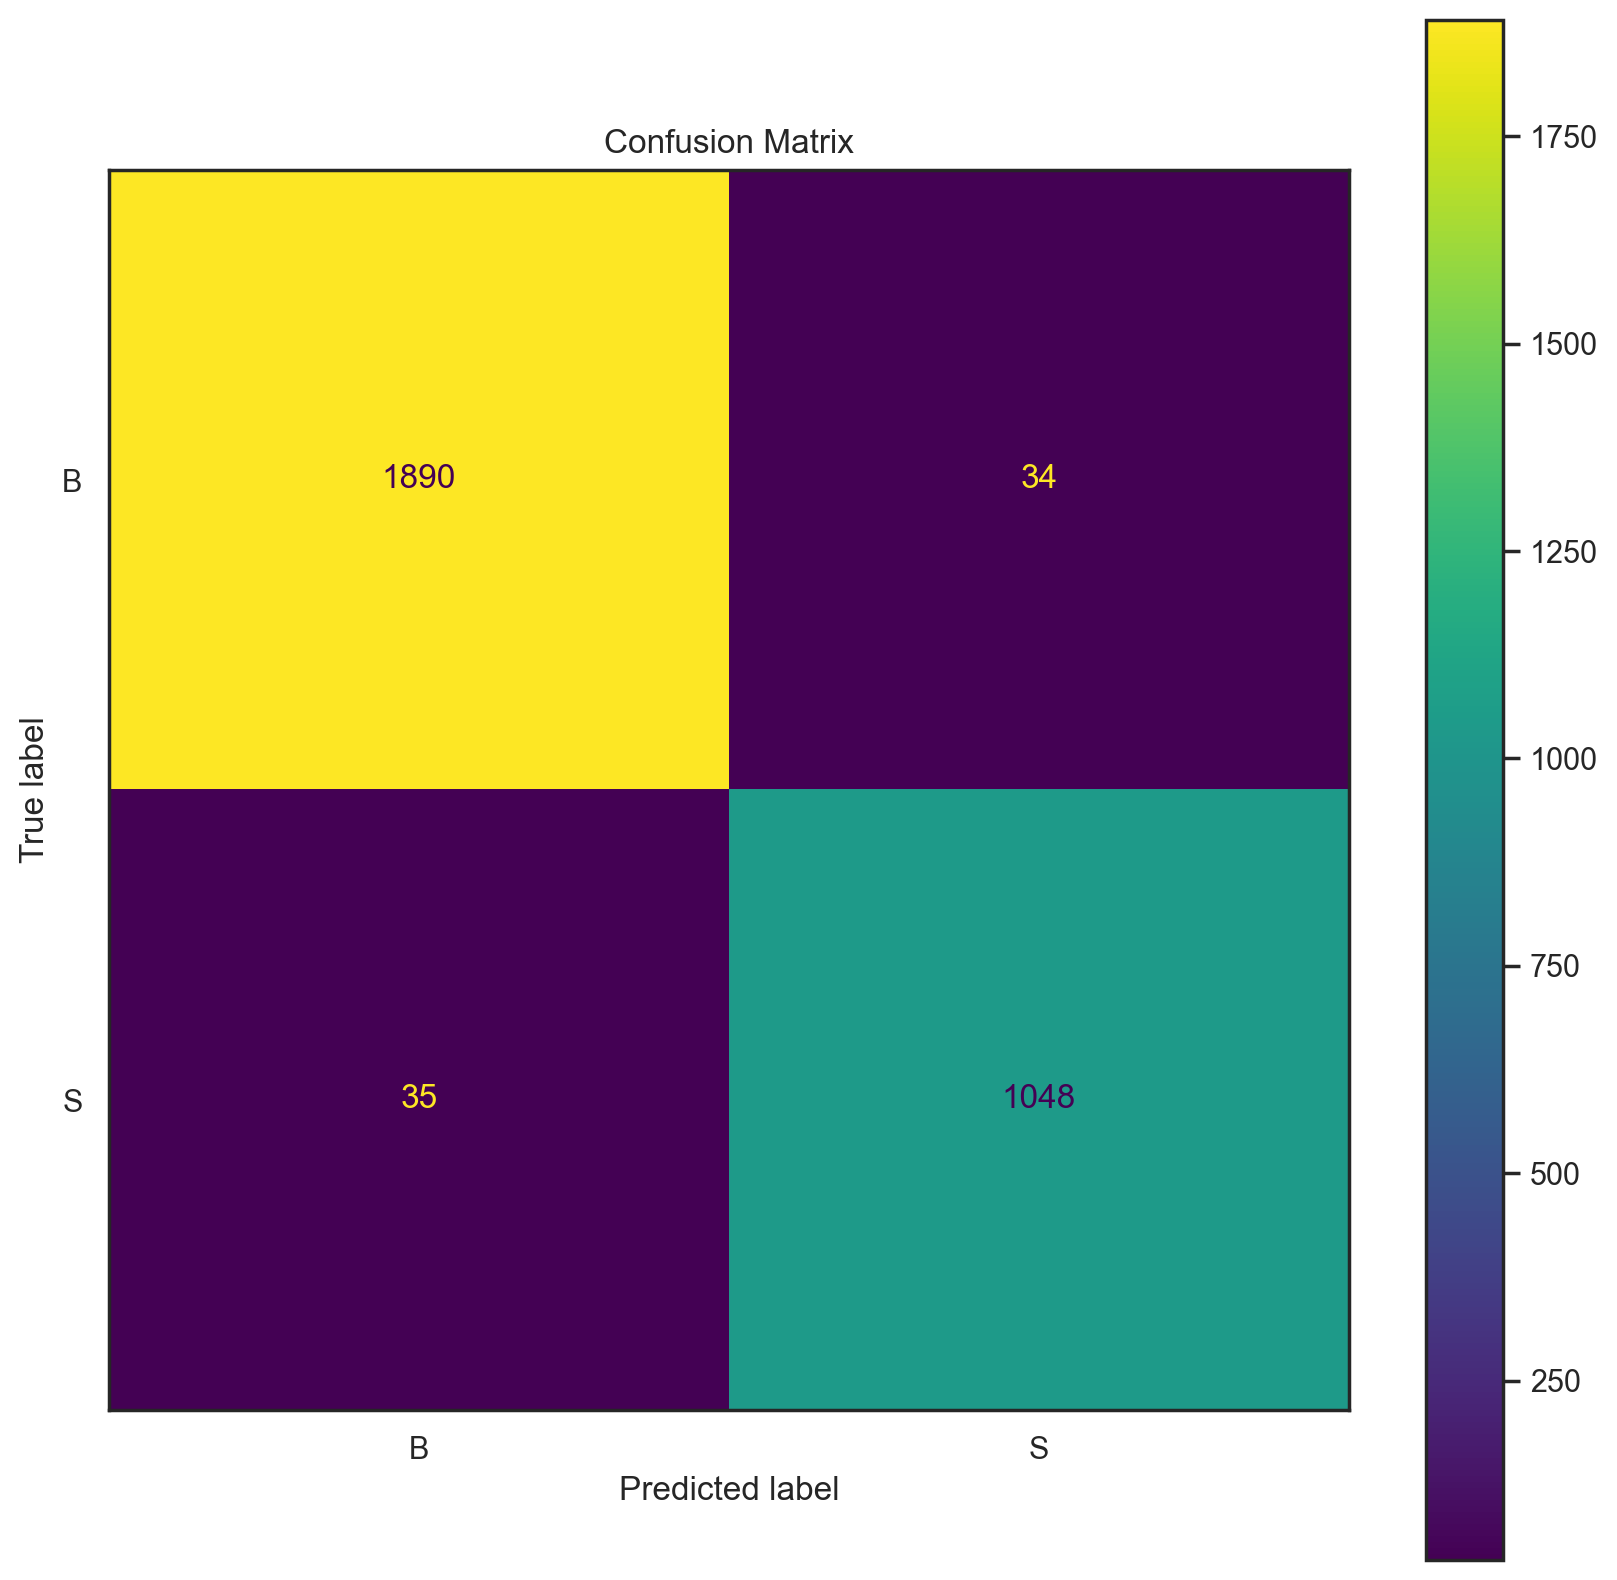

In [37]:
# Plot confusion matrix for test set
cm = confusion_matrix(y_pred, y_test)
with sns.axes_style("white"):  # Temporary hide Seaborn grid lines
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classes)
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title("Confusion Matrix")
    disp = disp.plot(ax=ax)
    plt.show()

In [38]:
# Compute additional metrics on test set
print(f"Precision: {precision_score(y_test, y_pred) * 100:.02f}%")
print(f"Recall: {recall_score(y_test, y_pred) * 100:.02f}%")

Precision: 96.77%
Recall: 96.86%
